## Explaining a random forest model - using a breast cancer dataset - with shap.


### **Overview**

Throughout this assignment, you will be performing specific well-defined tasks that’ll strengthen your concepts in Explainable AI. We will be using the Breast Cancer Dataset and here is a brief context about the same:

Breast cancer is a type of cancer that starts in the breast. Cancer starts when cells begin to grow out of control. Breast cancer cells usually form a tumor that can often be seen on an x-ray or felt as a lump. Breast cancer occurs almost entirely in women, but men can get breast cancer, too.
A benign tumor is a tumor that does not invade its surrounding tissue or spread around the body. A malignant tumor is a tumor that may invade its surrounding tissue or spread around the body.

As part of the assignment, you will have to accomplish the below tasks.

**Author:** Ayoub Berdeddouch

###**Dataset**

Dataset Link: https://raw.githubusercontent.com/dphi-official/Datasets/master/breast_cancer/Training_set_breastcancer.csv

**About the dataset:**

Different features related to the breast are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe the characteristics of the cell nuclei present in the image.


* id: Id number
* diagnosis: Cancer is Malignant or Benign (M = malignant, B = benign) - target variable

Other 20 features contain information about following 10 real valued features

* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values) 
* perimeter 
* area 
* smoothness (local variation in radius lengths) 
* compactness (perimeter^2 / area - 1.0) 
* concavity (severity of concave portions of the contour) 
* concave points (number of concave portions of the contour) 
* symmetry  
* fractal dimension ("coastline approximation" - 1)

# Task 1

## Import Necessary Libraries

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 15.3 MB/s 


In [ ]:
# python 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# shap
import shap
shap.initjs()

## Load the data
Display the first 5 rows of the data after loading.

In [ ]:
url = 'https://raw.githubusercontent.com/dphi-official/Datasets/master/breast_cancer/Training_set_breastcancer.csv'
data = pd.read_csv(url)
data.head(5)

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,914102,13.16,20.54,84.06,538.7,0.07335,0.05275,0.01800,0.01256,0.1713,...,28.46,95.29,648.3,0.1118,0.1646,0.07698,0.04195,0.2687,0.07429,B
1,91858,11.75,17.56,75.89,422.9,0.10730,0.09713,0.05282,0.04440,0.1598,...,27.98,88.52,552.3,0.1349,0.1854,0.13660,0.10100,0.2478,0.07757,B
2,88466802,10.65,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,...,35.19,77.98,455.7,0.1499,0.1398,0.11250,0.06136,0.3409,0.08147,B
3,9111843,12.00,28.23,76.77,442.5,0.08437,0.06450,0.04055,0.01945,0.1615,...,37.88,85.07,523.7,0.1208,0.1856,0.18110,0.07116,0.2447,0.08194,B
4,84862001,16.13,20.68,108.10,798.8,0.11700,0.20220,0.17220,0.10280,0.2164,...,31.48,136.80,1315.0,0.1789,0.4233,0.47840,0.20730,0.3706,0.11420,M


## Perform Basic Exploratory Data Analysis (EDA)

In [ ]:
data.shape

(398, 32)

In [ ]:
target = 'diagnosis'
y = data[target]
X = data
X.set_index('id', inplace=True) 
X.drop(columns=target,inplace=True)

In [ ]:
y.value_counts()

B    250
M    148
Name: diagnosis, dtype: int64

In [ ]:
# Encoding categorical value: malignant = 1 , benign = 0
y = y.map({'M':1,'B':0})

In [ ]:
# Ten real-valued features are computed for each cell nucleus
# for each one we have : the mean value, the standard error value (se) and 
# the worst value (mean of the three largest values).
# 10 features * 3 differents values => 30 features
X.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 914102 to 851509
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              398 non-null    float64
 1   texture_mean             398 non-null    float64
 2   perimeter_mean           398 non-null    float64
 3   area_mean                398 non-null    float64
 4   smoothness_mean          398 non-null    float64
 5   compactness_mean         398 non-null    float64
 6   concavity_mean           398 non-null    float64
 7   concave points_mean      398 non-null    float64
 8   symmetry_mean            398 non-null    float64
 9   fractal_dimension_mean   398 non-null    float64
 10  radius_se                398 non-null    float64
 11  texture_se               398 non-null    float64
 12  perimeter_se             398 non-null    float64
 13  area_se                  398 non-null    float64
 14  smoothness_se     

## Split the data into Train and Test Sets
The train to test ratio should be 80:20 and the random_state should be 0.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
print(X_train.shape,X_test.shape)

(318, 30) (80, 30)


# Task 2

## Use Random Forest Machine Learning Model for prediction

In [ ]:
clf=RandomForestClassifier(min_samples_split=10, 
                           min_samples_leaf=2, 
                           random_state=0)

In [ ]:
clf.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=10, random_state=0)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred[0:10]

array([1, 0, 1, 0, 0, 0, 0, 1, 1, 0])

## Evaluate the model using Accuracy Score

In [ ]:
print(f'{confusion_matrix(y_test, y_pred)}')

[[42  0]
 [ 3 35]]


In [ ]:
print(f'{classification_report(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        42
           1       1.00      0.92      0.96        38

    accuracy                           0.96        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.97      0.96      0.96        80



In [ ]:
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4}')

Accuracy: 0.9625


# Task 3: Explaining the model with SHAP and Lime.

##  Use a SHAP Explainer to derive SHAP Values for the random forest ml model.

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
explainer.expected_value

array([0.65572327, 0.34427673])

# Task 4

## Plot a SHAP force plot for the first row of test data.

In [ ]:
y_pred[0],y_test.iloc[0]

(1, 1)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][0,:],X_test.iloc[0,:])

## Write your inferences from the generated plot.

The predicted and diagnosis value is 1 (malignant), 
- the shap base value is 0.35, sample value is 0.73
- concave points_worst and perimeter_worst increase the probability of this prediction
- radius_worst decrease the probability of this prediction

# Task 5

## Plot a SHAP force plot for all the rows of the data

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], 
                shap_values[1],X_test)

## Write your inferences from the generated plot.

We can order together by similarity two major sets of sample:
- benign prediction (samples 12 to 50)  
- malignant prediction (samples 52 to 80)

For instance, we can notice in these two sets:  
  - in the case of a malignant prediction:  
    - area_worst > 1000 and perimeter_worst >100  

  - in the case of a benign prediction:  
    - area_worst < 700 and perimeter_worst <100


# Task 6

## Plot a SHAP summary plot using all the features in the data

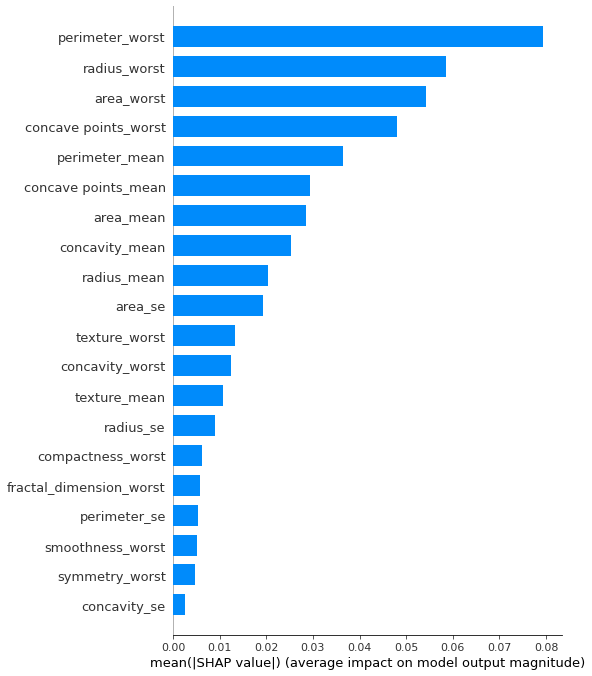

In [ ]:
shap.initjs()
shap.summary_plot(shap_values[1], 
                  X_test, plot_type="bar")

## Write your inferences from the generated plot.

The 4 top important features are:  
- perimeter_worst  
- radius_worst  
- area_worst  
- concave_points_worst

# Task 7

##Plot a SHAP dependence plot using all features in the data

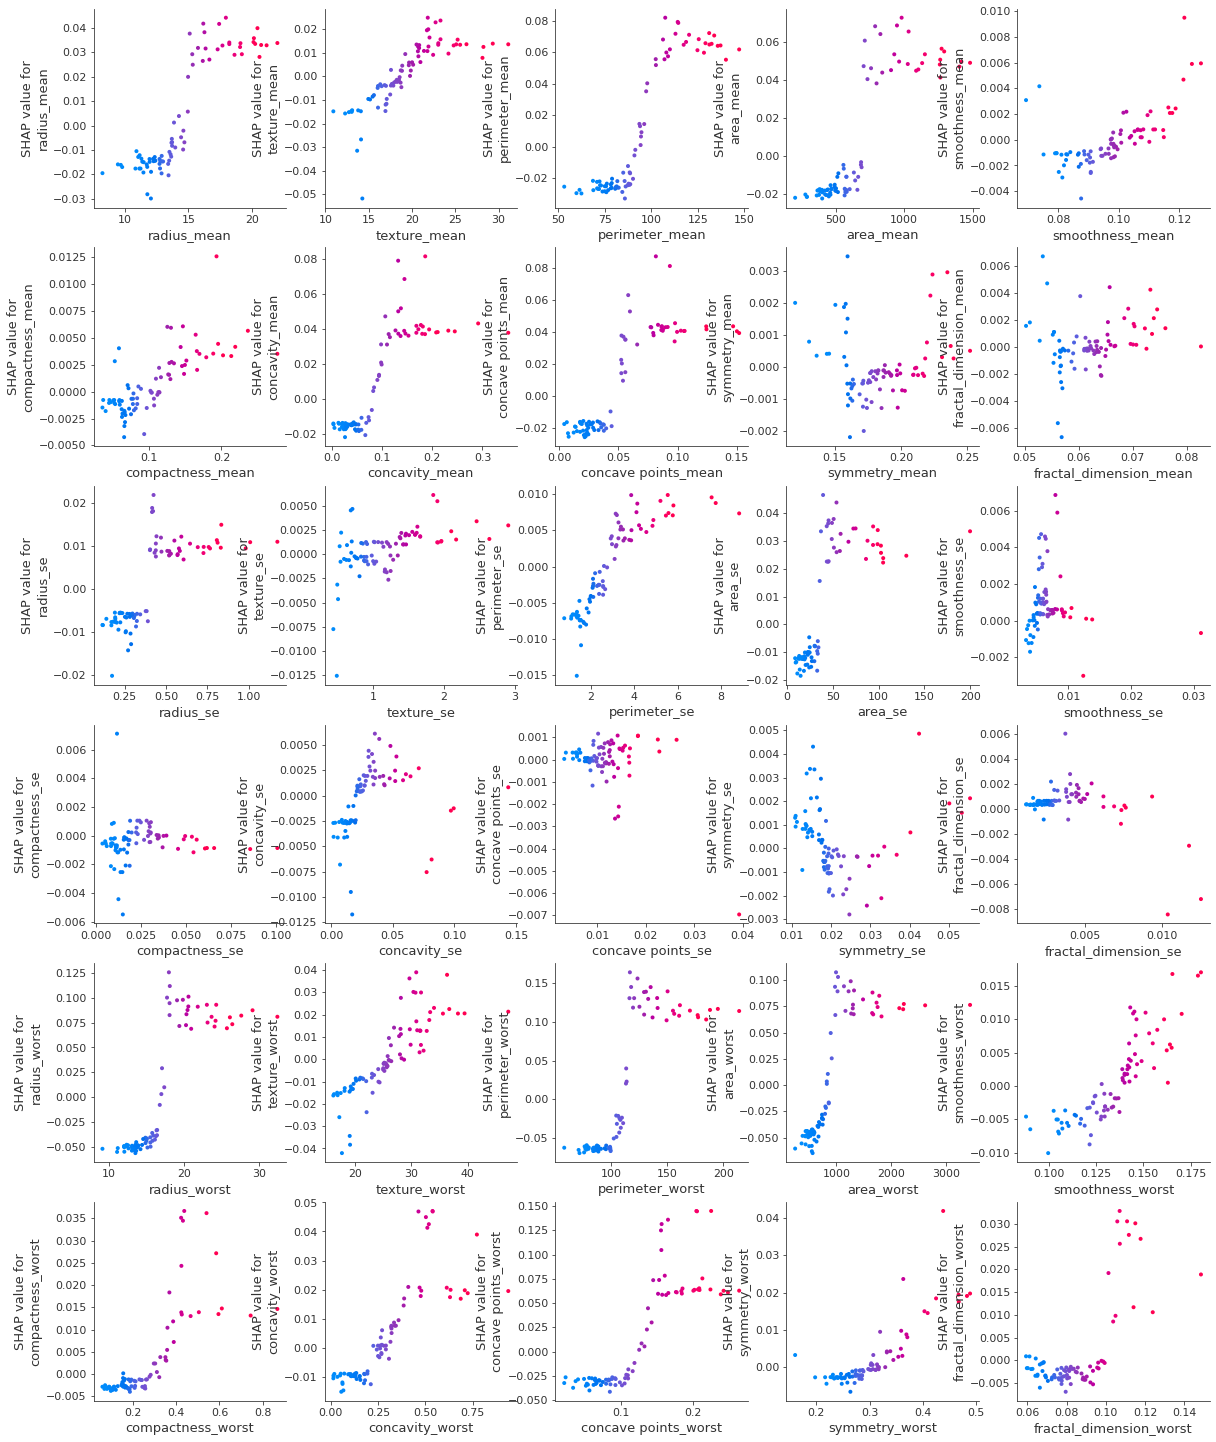

In [ ]:
fig = plt.figure(figsize=(20, 30))
for ind,col in enumerate(X_train.columns):
  axes = fig.add_subplot(7,5, ind+1)
  shap.dependence_plot(ind=col, interaction_index=col,
                     shap_values=shap_values[1], 
                     features=X_test,
                     ax=axes,
                     show=False)

## Write your inferences from the generated plot.

We can notice that some values increase progressively from low to high shap value. Others switch quickly, this means in that case that some values are sensitive to a threshold :  

Example:  
* if radius_worst is lower or higher than 18, the contribution to the prediction will be negative (benign) or positive (malignant).
* in the same way,  area_worst switch at 1000 and perimeter_worst at 125.

# Task 8 (Optional)

## Do anything and everything with SHAP
This is the section to explore what more you can do with SHAP. Create some meaningful visualisations and write down what you can infer from them. 

Who knows, this section might carry some bonus points.